<a href="https://colab.research.google.com/github/vvmnnnkv/swift-models/blob/fast-style/FastStyleTransfer/Demo/ColabDemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fast Style Transfer 🎨 with S4TF 



In [1]:
// Install package
%install-location $cwd/swift-packages
%install '.package(url: "https://github.com/tensorflow/swift-models.git", .branch("master"))' ModelSupport FastStyleTransfer


Installing packages:
	.package(url: "https://github.com/BradLarson/swift-models.git", .branch("FastStyleTransferImprovements"))
		ModelSupport
		FastStyleTransfer
With SwiftPM flags: []
Working in: /tmp/tmpbs17_twy/swift-install
[1/2] Compiling jupyterInstalledPackages jupyterInstalledPackages.swift
[2/3] Merging module jupyterInstalledPackages
Initializing Swift...
Installation complete!


In [2]:
import Foundation
import FoundationNetworking
import TensorFlow
import FastStyleTransfer
import ModelSupport


#if canImport(PythonKit)
    import PythonKit
#else
    import Python
#endif

// Imaging capabilities
%include "EnableIPythonDisplay.swift"
let plt = Python.import("matplotlib.pyplot")
IPythonDisplay.shell.enable_matplotlib("inline")

// Display Tensor
func show_img<T>(_ img: Tensor<T>, _ w: Int = 8, _ h: Int = 6) where T: NumpyScalarCompatible {
    plt.figure(figsize: [w, h])
    plt.imshow(img.makeNumpyArray())
    plt.show()  
}

// Load JPEG
func loadJpegAsTensor(from file: String) throws -> Tensor<Float> {
    let imgData = Raw.readFile(filename: StringTensor(file))
    return Tensor<Float>(Raw.decodeJpeg(contents: imgData, channels: 3, dctMethod: "")) / 255
}

// Download file
func downloadFile(from url: String, to file: String) {
  let content = try! Data(contentsOf: URL(string: url)!)
  FileManager.default.createFile(atPath: file, contents: content)
}

[240, 240, 3]


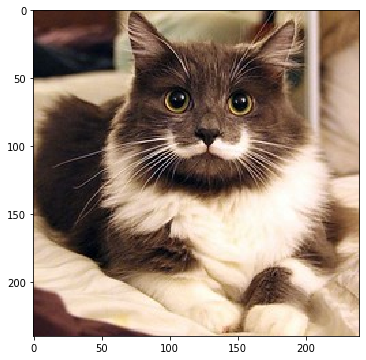

In [3]:
// Load the hipster cat!
downloadFile(from: "https://live.staticflickr.com/1624/23552974149_bd3ca7d0dd_m_d.jpg", to: "cat.jpg")
let image = loadJpegAsTensor(from: "cat.jpg")

print(image.shape)
show_img(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


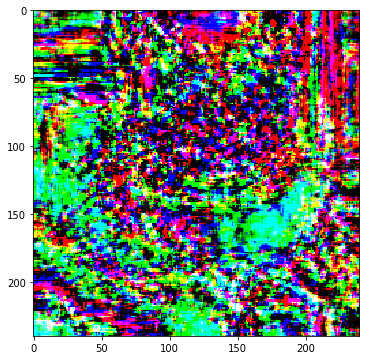

In [4]:
// Test with non-initialized model
var style = TransformerNet()
let out_random = style(image.expandingShape(at: 0))
show_img(out_random.squeezingShape(at: 0))

In [5]:
// Import weights into the model, extend it with hacky importer
extension TransformerNet: ImportableLayer {}

// Map of model params to loaded params
// Names don't match exactly, and axes in filters need to be reversed
let map = [
    "conv1.conv2d.filter": ("conv1.conv2d.weight", [3, 2, 1, 0]),
    "conv2.conv2d.filter": ("conv2.conv2d.weight", [3, 2, 1, 0]),
    "conv3.conv2d.filter": ("conv3.conv2d.weight", [3, 2, 1, 0]),
    "deconv1.conv2d.filter": ("deconv1.conv2d.weight", [3, 2, 1, 0]),
    "deconv2.conv2d.filter": ("deconv2.conv2d.weight", [3, 2, 1, 0]),
    "deconv3.conv2d.filter": ("deconv3.conv2d.weight", [3, 2, 1, 0]),
    "res1.conv1.conv2d.filter": ("res1.conv1.conv2d.weight", [3, 2, 1, 0]),
    "res1.conv2.conv2d.filter": ("res1.conv2.conv2d.weight", [3, 2, 1, 0]),
    "res1.in1.scale": ("res1.in1.weight", nil),
    "res1.in1.offset": ("res1.in1.bias", nil),
    "res1.in2.scale": ("res1.in2.weight", nil),
    "res1.in2.offset": ("res1.in2.bias", nil),
    "res2.conv1.conv2d.filter": ("res2.conv1.conv2d.weight", [3, 2, 1, 0]),
    "res2.conv2.conv2d.filter": ("res2.conv2.conv2d.weight", [3, 2, 1, 0]),
    "res2.in1.scale": ("res2.in1.weight", nil),
    "res2.in1.offset": ("res2.in1.bias", nil),
    "res2.in2.scale": ("res2.in2.weight", nil),
    "res2.in2.offset": ("res2.in2.bias", nil),
    "res3.conv1.conv2d.filter": ("res3.conv1.conv2d.weight", [3, 2, 1, 0]),
    "res3.conv2.conv2d.filter": ("res3.conv2.conv2d.weight", [3, 2, 1, 0]),
    "res3.in1.scale": ("res3.in1.weight", nil),
    "res3.in1.offset": ("res3.in1.bias", nil),
    "res3.in2.scale": ("res3.in2.weight", nil),
    "res3.in2.offset": ("res3.in2.bias", nil),
    "res4.conv1.conv2d.filter": ("res4.conv1.conv2d.weight", [3, 2, 1, 0]),
    "res4.conv2.conv2d.filter": ("res4.conv2.conv2d.weight", [3, 2, 1, 0]),
    "res4.in1.scale": ("res4.in1.weight", nil),
    "res4.in1.offset": ("res4.in1.bias", nil),
    "res4.in2.scale": ("res4.in2.weight", nil),
    "res4.in2.offset": ("res4.in2.bias", nil),
    "res5.conv1.conv2d.filter": ("res5.conv1.conv2d.weight", [3, 2, 1, 0]),
    "res5.conv2.conv2d.filter": ("res5.conv2.conv2d.weight", [3, 2, 1, 0]),
    "res5.in1.scale": ("res5.in1.weight", nil),
    "res5.in1.offset": ("res5.in1.bias", nil),
    "res5.in2.scale": ("res5.in2.weight", nil),
    "res5.in2.offset": ("res5.in2.bias", nil),
    "in1.scale": ("in1.weight", nil),
    "in1.offset": ("in1.bias", nil),
    "in2.scale": ("in2.weight", nil),
    "in2.offset": ("in2.bias", nil),
    "in3.scale": ("in3.weight", nil),
    "in3.offset": ("in3.bias", nil),
    "in4.scale": ("in4.weight", nil),
    "in4.offset": ("in4.bias", nil),
    "in5.scale": ("in5.weight", nil),
    "in5.offset": ("in5.bias", nil),
]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


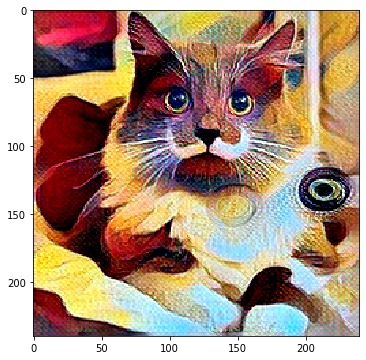

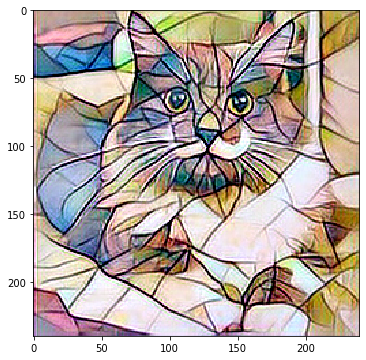

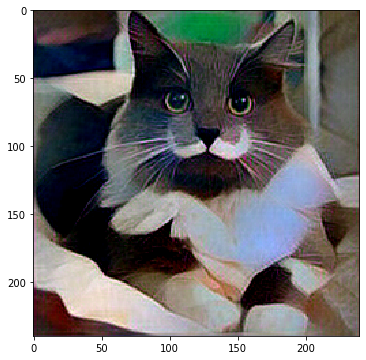

In [6]:
// Perform the style transfer, for each of three styles.
let styles = ["candy", "mosaic", "udnie"] 
for s in styles {
  // Download weight checkpoints.
  let remoteCheckpoint = URL(
    string: "https://storage.googleapis.com/s4tf-hosted-binaries/checkpoints/FastStyleTransfer/\(s)")!
  let modelName = "FastStyleTransfer_\(s)"
  let reader = try! CheckpointReader(checkpointLocation: remoteCheckpoint, modelName: modelName)
  // Load weights into model.
  style.unsafeImport(from: reader, map: map)
  // Apply model to image.
  let out = style(image.expandingShape(at: 0))  / 255
  show_img(out.squeezingShape(at: 0))
}